In [47]:
from utils.converters import df_to_XY
from utils.readers import read_quarterly
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = read_quarterly()
x_index = ['GDP', 'FOREX', 'CPI', 'Interest_rate', 'SMI']
y_index = ['Net_value', 'Net_num']

X, Y = df_to_XY(df, xkeys=x_index, ykeys=y_index)

In [3]:
X

array([[4.15481e+05, 8.08192e+01, 4.10000e+00, 6.20000e-01, 3.06773e+03],
       [4.12922e+05, 7.94364e+01, 4.40000e+00, 6.50000e-01, 3.09672e+03],
       [4.17021e+05, 7.92172e+01, 4.70000e+00, 6.30000e-01, 2.65438e+03],
       [4.18787e+05, 8.03030e+01, 4.70000e+00, 7.60000e-01, 2.85788e+03],
       [4.23769e+05, 8.11729e+01, 3.50000e+00, 6.50000e-01, 3.00278e+03],
       [4.24990e+05, 8.31546e+01, 2.70000e+00, 7.10000e-01, 2.89145e+03],
       [4.32881e+05, 8.36268e+01, 2.70000e+00, 6.70000e-01, 3.09341e+03],
       [4.38017e+05, 8.03229e+01, 2.80000e+00, 6.10000e-01, 3.38064e+03],
       [4.42531e+05, 8.05181e+01, 2.70000e+00, 6.70000e-01, 3.28971e+03],
       [4.49539e+05, 8.12328e+01, 2.70000e+00, 4.80000e-01, 3.44385e+03],
       [4.72764e+05, 8.72800e+01, 9.00000e-01, 3.50000e-01, 3.53274e+03],
       [4.81007e+05, 9.28411e+01, 0.00000e+00, 3.50000e-01, 3.33592e+03],
       [4.87418e+05, 9.21341e+01, 1.00000e-01, 4.00000e-01, 3.44426e+03],
       [4.95831e+05, 8.55019e+01, 4.00

In [4]:
Y

array([[ 1.1740e+04,  1.3000e+01],
       [ 4.2620e+03,  3.0000e+00],
       [-2.5000e+01,  4.0000e+00],
       [-1.0730e+03,  1.8000e+01],
       [-5.5180e+03, -2.6000e+01],
       [ 2.4460e+03, -1.4000e+01],
       [ 8.4200e+02,  9.0000e+00],
       [-7.0080e+03,  2.0000e+00],
       [-2.5323e+04, -2.5000e+01],
       [-2.1250e+03, -4.9000e+01],
       [ 7.0900e+03,  9.0000e+00],
       [-3.8230e+03,  2.0000e+00],
       [-1.4028e+04, -5.0000e+00],
       [-2.1736e+04, -2.9000e+01],
       [-6.4080e+03, -2.8000e+01],
       [ 1.5580e+04, -2.9000e+01],
       [ 3.4249e+04, -3.0000e+01],
       [ 1.6130e+03, -1.8000e+01],
       [-1.4576e+04, -9.5000e+01],
       [-4.1860e+03, -9.0000e+01],
       [-3.2990e+03, -4.4000e+01],
       [-2.8087e+04, -5.0000e+01],
       [ 1.4800e+03, -2.4000e+01],
       [-1.6839e+04, -8.4000e+01],
       [-9.1020e+03, -9.3000e+01],
       [-9.2960e+03, -6.9000e+01],
       [-5.9100e+03, -5.5000e+01],
       [-4.4920e+03, -3.6000e+01],
       [-3.1560e+03,

In [5]:
reg = LinearRegression().fit(X, Y)
reg.score(X, Y)

0.43423734438731343

In [6]:
reg.coef_

array([[-1.53676500e-01, -5.16844568e+01,  3.10840442e+03,
        -3.34545361e+04,  7.32073419e+00],
       [-4.65218820e-04,  1.41132181e+00, -1.54553754e+00,
         2.05746479e+01,  1.69660550e-03]])

In [7]:
reg.intercept_

array([56785.97891923,    70.66687635])

In [42]:
print(X)

[[4.15481e+05 8.08192e+01 4.10000e+00 6.20000e-01 3.06773e+03]
 [4.12922e+05 7.94364e+01 4.40000e+00 6.50000e-01 3.09672e+03]
 [4.17021e+05 7.92172e+01 4.70000e+00 6.30000e-01 2.65438e+03]
 [4.18787e+05 8.03030e+01 4.70000e+00 7.60000e-01 2.85788e+03]
 [4.23769e+05 8.11729e+01 3.50000e+00 6.50000e-01 3.00278e+03]
 [4.24990e+05 8.31546e+01 2.70000e+00 7.10000e-01 2.89145e+03]
 [4.32881e+05 8.36268e+01 2.70000e+00 6.70000e-01 3.09341e+03]
 [4.38017e+05 8.03229e+01 2.80000e+00 6.10000e-01 3.38064e+03]
 [4.42531e+05 8.05181e+01 2.70000e+00 6.70000e-01 3.28971e+03]
 [4.49539e+05 8.12328e+01 2.70000e+00 4.80000e-01 3.44385e+03]
 [4.72764e+05 8.72800e+01 9.00000e-01 3.50000e-01 3.53274e+03]
 [4.81007e+05 9.28411e+01 0.00000e+00 3.50000e-01 3.33592e+03]
 [4.87418e+05 9.21341e+01 1.00000e-01 4.00000e-01 3.44426e+03]
 [4.95831e+05 8.55019e+01 4.00000e-01 4.20000e-01 3.51545e+03]
 [5.14616e+05 7.70433e+01 2.10000e+00 2.40000e-01 3.99000e+03]
 [5.18217e+05 7.79419e+01 2.70000e+00 2.10000e-01 4.002

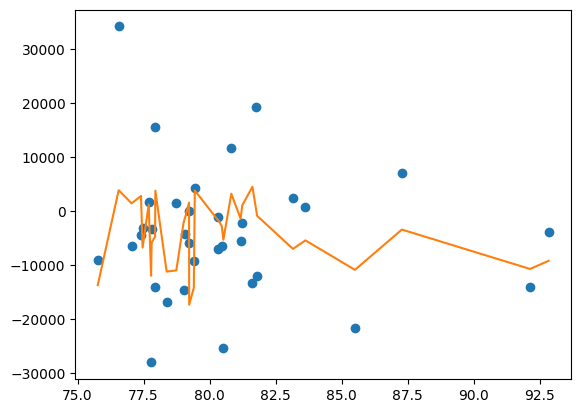

In [64]:
ax = plt.gca()

_xindex = 1  # ['GDP', 'FOREX', 'CPI', 'Interest_rate', 'SMI']
_yindex = 0  # [value, num]

x = X[:, _xindex]
y = Y[:, _yindex]
beta = reg.coef_
const =  reg.intercept_[_yindex]

Y_pred = X @ beta.T + const
y_pred = Y_pred[:, _yindex]

ax.plot(x, y, marker='o', ls="")
index = np.argsort(x)
ax.plot(x[index], y_pred[index])

In [58]:
beta

array([[-1.53676500e-01, -5.16844568e+01,  3.10840442e+03,
        -3.34545361e+04,  7.32073419e+00],
       [-4.65218820e-04,  1.41132181e+00, -1.54553754e+00,
         2.05746479e+01,  1.69660550e-03]])